In [ ]:
# Data analysis and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning

# Loadind dataset
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
combine = [train_df, test_df]

In [206]:
# Exploring dataset
train_df.head()
test_df.head()

# Qualitative  - Nominal: Survived, Sex, Embarked, Name, Ticket, Cabin
# Qualitative  - Ordinal: Pclass

# Quantitative - Continuous: Age, Fare
# Quantitative - Discrete: SibSp, Parch

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [207]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [208]:
# There are some variables with null data that need to be filled in
print(f'Train Nulls:\n\n{train_df.isnull().sum()}\n\nTest Nulls:\n\n{test_df.isnull().sum()}')

Train Nulls:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Nulls:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [209]:
# Deleting cabin and ticket variables given the irrelevance for prediction
train_df = train_df.drop(columns=['Cabin', 'Ticket'])
test_df = test_df.drop(columns=['Cabin', 'Ticket'])
combine = [train_df, test_df]

In [210]:
# Deleting name and id variables given the irrelevance for prediction
train_df = train_df.drop(columns=['Name', 'PassengerId'])
test_df = test_df.drop(columns=['Name'])
combine = [train_df, test_df]

In [211]:
# Given most common embarked place to the null data
most_common = train_df['Embarked'].mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(most_common)
test_df['Embarked'] = test_df['Embarked'].fillna(most_common)

def impute_variable(row, variable, medians_dict, group_cols=('Pclass','Sex')):
    if pd.isnull(row[variable]):
        key = tuple(row[col] for col in group_cols)
        return medians_dict.loc[key]
    else:
        return row[variable]
        
# Given the media fare group by pclass and sex for the pclass to the only null fare in test
fare_median = train_df.groupby(['Pclass','Sex'])['Fare'].mean()
test_df['Fare'] = test_df.apply(impute_variable, axis=1, variable='Fare', medians_dict=fare_median)

# Given the median age group by pclass and sex to the null ages
age_median = train_df.groupby(['Pclass','Sex'])['Age'].median()
train_df['Age'] = train_df.apply(impute_variable, axis=1, variable='Age', medians_dict=age_median)
test_df['Age'] = test_df.apply(impute_variable, axis=1, variable='Age', medians_dict=age_median)

print(f'Train Nulls:\n\n{train_df.isnull().sum()}\n\nTest Nulls:\n\n{test_df.isnull().sum()}')

Train Nulls:

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Test Nulls:

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


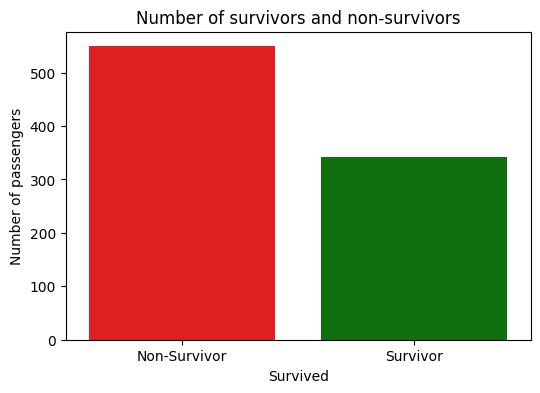

In [212]:
# Number of survivors
survival_counts = train_df['Survived'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=survival_counts.index, y=survival_counts.values, palette=['red','green'])
plt.title('Number of survivors and non-survivors')
plt.ylabel('Number of passengers')
plt.xticks([0,1], ['Non-Survivor', 'Survivor'])
plt.show()

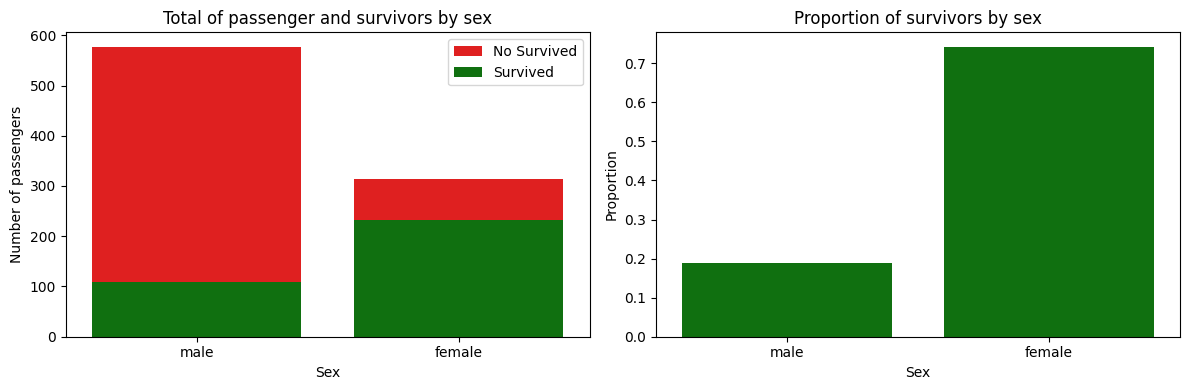

In [213]:
# Total passengers and survivors by sex and proportion
sex_counts = train_df['Sex'].value_counts()
survivors_by_sex = train_df.groupby('Sex')['Survived']
sex_survivors = survivors_by_sex.sum()
sex_proportion = survivors_by_sex.mean()

sex_survivors = sex_survivors.reindex(sex_counts.index)
sex_proportion = sex_proportion.reindex(sex_counts.index)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=sex_counts.index, y=sex_counts.values, color='red', label="No Survived", ax=axes[0])
sns.barplot(x=sex_survivors.index, y=sex_survivors.values, color='green', label="Survived", ax=axes[0])
axes[0].set_title('Total of passenger and survivors by sex')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x=sex_proportion.index, y=sex_proportion.values, color='green', ax=axes[1])
axes[1].set_title('Proportion of survivors by sex')
axes[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

# Survivor by sex and age


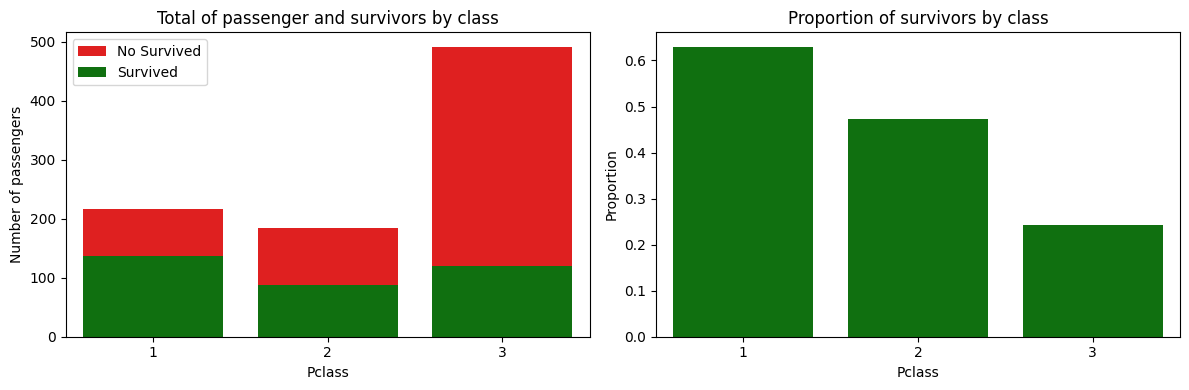

In [214]:
# Total passengers and survivors by class and proportion
survivors_counts = train_df['Pclass'].value_counts()
survivors_by_class = train_df.groupby('Pclass')['Survived']
class_survivors = survivors_by_class.sum()
class_proportion = survivors_by_class.mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=survivors_counts.index, y=survivors_counts.values, color='red', label="No Survived", ax=axes[0])
sns.barplot(x=class_survivors.index, y=class_survivors.values, color='green', label="Survived", ax=axes[0])
axes[0].set_title('Total of passenger and survivors by class')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x=class_proportion.index, y=class_proportion.values, color='green', ax=axes[1])
axes[1].set_title('Proportion of survivors by class')
axes[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()


# Survivor by class and sex


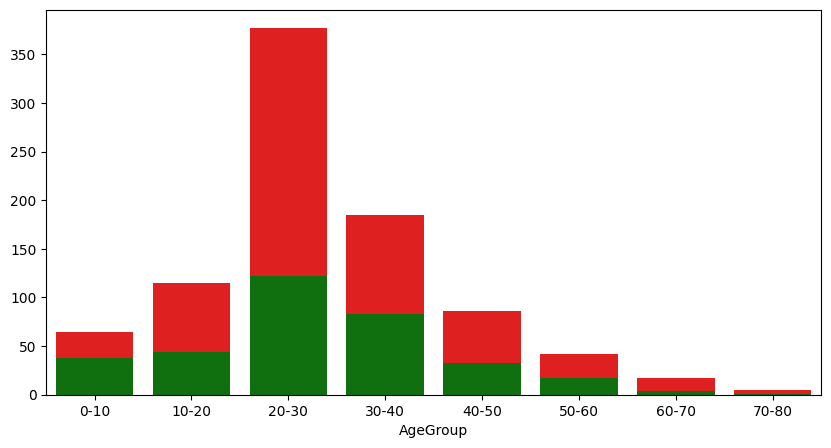

In [ ]:
# Total passengers and survivors by age
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80']

train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=bins, labels=labels)
age_counts = train_df['AgeGroup'].value_counts().reindex(labels)
age_survivors = train_df.groupby('AgeGroup', observed='True')['Survived'].sum().reindex(labels)

plt.figure(figsize=(10,5))
sns.barplot(x=age_counts.index, y=age_counts.values, color='red', label='No Survived')
sns.barplot(x=age_survivors.index, y=age_survivors.values, color='green', label='Survived')
plt.title('Total passengers and survivors by age group')
plt.ylabel('Number of passengers')
plt.legend()

plt.show()

# Survivor by class and age


In [216]:
# Total passengers and survivors by fare

# Correlation